In [1]:
import json
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis

sys.path.insert(0, "../")
from scgpt.utils import set_seed, map_raw_id_to_vocab_id, compute_perturbation_metrics

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


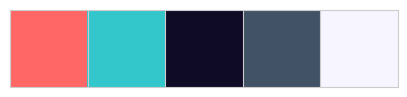

In [2]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [3]:
def get_subgroup_metrcs(_preds, _pert_data):

    pert_cat = _preds["pert_cat"]
    true = _preds["truth"]
    pred = _preds["pred"]

    ctrl_adata = _pert_data.adata[_pert_data.adata.obs["condition"] == "ctrl"]
    mean_ctrl = np.array(ctrl_adata.X.mean(0)).flatten() 

    pert_res = {}

    for _pert, _true, _pred in zip(pert_cat, true, pred):
        myr = pearsonr(_true - mean_ctrl, _pred - mean_ctrl)[0]

        pert_res[_pert] = myr

    test_subgroup = _pert_data.subgroup["test_subgroup"]
    subgroup_analysis = {}
    for name in test_subgroup.keys():
        subgroup_analysis[name] = []

    from collections import defaultdict
    category_cnt = defaultdict(int)

    for k, v in pert_res.items():
        for category, cat_pert in test_subgroup.items():
            if k in cat_pert:
                subgroup_analysis[category].append(v)
                category_cnt[category] += 1

    print(category_cnt)

    for k, v in subgroup_analysis.items():
        subgroup_analysis[k] = np.mean(v)
    
    return subgroup_analysis

In [4]:
pert_data = PertData("./data")
pert_data.load(data_name="norman")
pert_data.prepare_split(split="simulation", seed=1)

Found local copy...


Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


In [5]:
def get_norman_bulk_metrics(dir: Path, pert_data):
    feature_name_map = {
        "go": "go",
        "elmo": "scElmo",
        "foundation": "scFoundation",
        "gpt": "scGPT",
    }
    res_dict = {}
    for model in ["RF", "EN", "KNN"]:
        for feature in ["go", "elmo", "foundation", "gpt"]:
            _pred_dict = np.load(dir / model / feature / "test_res_best_model.npz", allow_pickle=True)
            _pred_dict = {k: v for k, v in _pred_dict.items()}
            res_dict[f"{model}_{feature_name_map[feature]}"] = get_subgroup_metrcs(_pred_dict, pert_data)
    
    _pred_dict_mean = np.load(dir / "mean" / "test_res_best_model.npz", allow_pickle=True)
    res_dict["mean"] = get_subgroup_metrcs(_pred_dict_mean, pert_data)

    return res_dict

In [6]:
myout = get_norman_bulk_metrics(Path("./save/norman"), pert_data)

test_preds_scgpt = np.load("./save/dev_perturb_norman-Sep24-13-29/test_res_best_model.npz")
test_preds_scgpt = {k: v for k, v in test_preds_scgpt.items()}

test_preds_scfound = np.load("../scFoundation/GEARS/results/norman/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.01/2025-02-12_00-47-27/test_res_best_model.npz")

myout["scGPT"] = get_subgroup_metrcs(test_preds_scgpt, pert_data)
myout["scFoundation"] = get_subgroup_metrcs(test_preds_scfound, pert_data)

defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18,

In [7]:
myres = pd.DataFrame(myout).T

In [9]:
# res_df to long format
myres_long = myres.stack().reset_index().rename(columns={"level_0": "model", "level_1": "subgroup", 0: "pearson_delta"})

In [10]:
hue_colors = {
    "combo_seen0": "#FF6666",
    "combo_seen1": "#0F0A26",
    "combo_seen2": "#425266",
    "unseen_single": "#33C7CC"
}

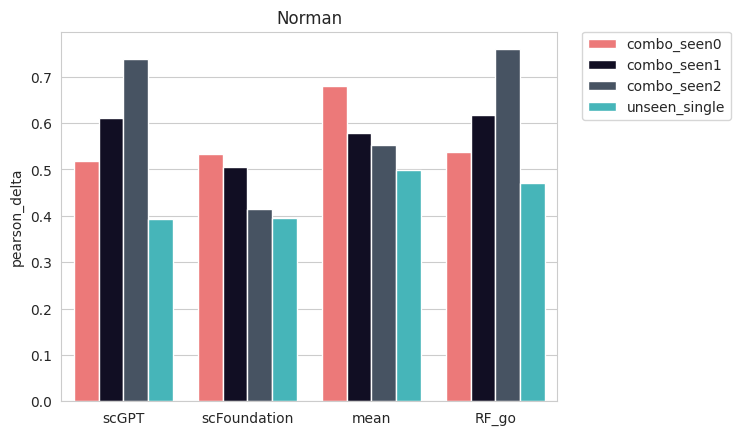

In [11]:
first_models = ["scGPT", "scFoundation", "mean", "RF_go"]
second_models = ["RF_go", "RF_scElmo", "RF_scFoundation", "RF_scGPT"]

myfirst = myres_long[myres_long["model"].isin(first_models)]
mysecond = myres_long[myres_long["model"].isin(second_models)]

sns.barplot(data=myfirst, x="model", y="pearson_delta", hue="subgroup", order=first_models, palette=hue_colors)

# set legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("")
plt.title("Norman")

plt.savefig("../figures/models/Norman_first_models_dd.png", dpi=300, bbox_inches="tight")
plt.savefig("../figures/models/Norman_first_models_dd.pdf")

plt.show()

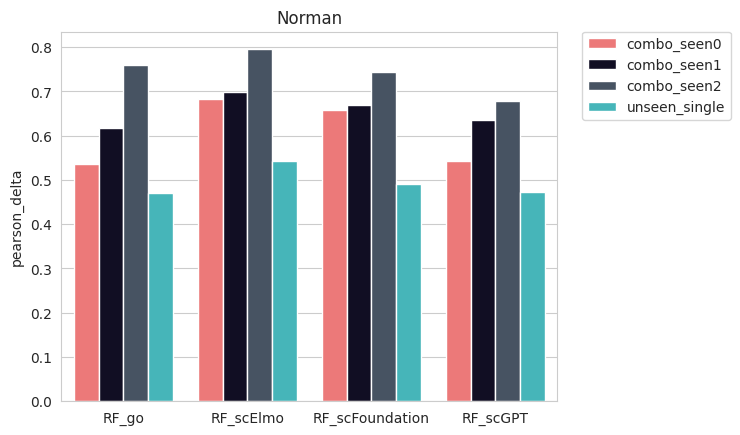

In [12]:
sns.barplot(data=mysecond, x="model", y="pearson_delta", hue="subgroup", order=second_models, palette=hue_colors)

# set legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("")
plt.title("Norman")

plt.savefig("../figures/models/Norman_second_models_dd.png", dpi=300, bbox_inches="tight")
plt.savefig("../figures/models/Norman_second_models_dd.pdf")

plt.show()

In [13]:
myres.to_csv("../figures/models/Norman_subgroup_metrics.csv")